# Predicting Missing Fitbit Data

## Summary of Findings

### 1. Who Is Armstrong?
Armstrong has a generally sedentary lifestyle.  However, from April towards the end of the year, he seems to have increased attention to his activity level and overall fitness.

His calorie (overall or activity) trended up from April to December, except in September where he seems to dipped down on his fitness level.  However, he did seem to try to incorporate more steps and use more stairs. Until November and December, he significantly increased the amount of high intensity activities.  

Armstrong even tried to record his food intake! However, he only managed to do it a few times, which was 2018-05-31 & 2018-11-03 through 2018-11-10.  It is noteworthy that the 7 consecutive days where he managed to record food log also reflected the peak of his calorie burned and activity logs. Seems like there was a burst of motivation!

Looking at the seasonality in the data, it seems like Armstrong has "weekly habits". He is more active toward the later part of the week.

We therefore conclude that Armstrong has a typical M-F job and the "seasonality" we see reflects a weekly work schedule, with more time to spare on fitness on the weekends.

Adding a bit more light activities throughout Mondays might significantly bring up Armstrong's overall exercise rate.

### 2. Modeling and Forecasting
As we run different models on the 7 attributes with missing values, we reckon that some models gave us a lower Root Mean Squared Error than others. Below is a list of the "best model" used for the attributes in question.

- Steps - Holt's Exponential Smoothing  
- Distance - Moving Average
- Floors - Holt's Exponential Smoothing
- Minutes of being Lightly Active - Holt's Exponential Smoothing
- Minutes of being Fairly Active - Holt's Linear
- Minutes of being Very Active - Holt's Exponential Smoothing
- Calorie from Activity - Holt's Exponential Smoothing

After identifying the "best model" for each attribute (lowest RMSE), we run the respective models on new train and test with the test being the missing 2 weeks of data, and arrived at prediction values that make sense.

In the imputation part, we saw that the missing weeks were characterized by "Lazy Days", a loose term denoting days where `cal_burn` and `cal_activity` values are below the median. Specifically, the days with missing values have cal_burn of 2000-2500, when the median cal_burn is 3302.5 in train.

The final predictions mimic these "Lazy Days" with values of low physical activity.

---
## Project Plan

### Goals
 - Predict missing values from the data set using clustering
 - Derive insights on "Armstrong", the person from whom the fitness data was generated

### Hypotheses
 - There are patterns on Armstrong's daily activities.
 - Armstrong's fitness activity is affected by the month/season of the year.

### Data Science Skills Used
 - Data prep and cleaning
 - Time Series Analysis
 - Visualization
 - Modeling using Parametric Methods
 - Modeling using the Prophet algorithm
 - Evaluation of Models

---
## Data Dictionary

| Column name (original) 	| Column (analysis report) 	| Description                                            	|
|------------------------	|--------------------------	|--------------------------------------------------------	|
| Date                   	| date                     	| 2018-04-26 to 2018-12-06 Pandas datetime format.       	|
|                        	|                          	| Set as the index of dataframe for time series analysis 	|
| Calories Burned        	| col_burn                 	| Daily total calories burned, in cal                    	|
| Steps                  	| steps                    	| Daily total step count                                 	|
| Distance               	| distance                 	| Daily walking distance                                 	|
| Floors                 	| floors                   	| Daily number of floors climbed                         	|
| Minutes Sedentary      	| min_sed                  	| Daily minutes in sedentary                             	|
| Minutes Lightly Active 	| min_active_light         	| Dilay light activity, in minutes                       	|
| Minutes Fairly Active  	| min_active_fairly        	| Dilay medium activity, in minutes                      	|
| Minutes Very Active    	| min_active_very          	| Dilay intense activity, in minutes                     	|
| Activity Calories      	| cal_activity             	| Daily total calories burned from activity, in cal      	|

---
## Notes on the Fitbit Data:

We are given eight .csv files that hold monthly data of an individual, whom we elect to call "Armstrong". Before we begin wrangling the data, we peruse all the files and made initial notes as follows:

1. The "missing" data is from 6/27/2018 - 7/6/2018 on the following variables:
  - Steps
  - Distance
  - Floors
  - Lightly Active in Minutes
  - Fairly Active in Minutes
  - Very Active in Minutes
2. Food/ Food log data is almost empty. There are only 1 record available in May-June data, and 7 records in the October-November data.
3. The data range covers April 26, 2018 to December 6, 2018.

### Packages

In [2]:
# data manipulation 
import numpy as np
import pandas as pd

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from sklearn import metrics


import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warning
import warnings
warnings.filterwarnings("ignore")

# project_specific modules
import acquire
import model

## I. Acquire and Preprocess

### A. Acquire

We manipulated the individual csv files from Excel, and decided to create a single .csv file as the size of the data is manageable. We only wanted the activity data, and not the food/food log data which barely contain any data.

`act.csv` is the csv file that integrates all relevant activitiy data from the eight .csv files provided.

`get_activity` function from the acquire.py module produces a data frame out of `act.csv` and renames the columns for efficiency.

In [3]:
df = acquire.get_activity()

Look at data and see if there are nulls and inappropriate data types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                 225 non-null object
cal_burn             225 non-null object
steps                225 non-null object
distance             225 non-null float64
floors               225 non-null int64
min_sed              225 non-null object
min_active_light     225 non-null int64
min_active_fairly    225 non-null int64
min_active_very      225 non-null int64
cal_activity         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB


- There are no nulls in the data set.
- Apart from `date` which will be handled later, there are four columns that are object type, namely.
  - cal_burn
  - steps
  - min_sed
  - cal_activity

In [5]:
df.sample(5) #inspect the object-type attributes, why are they being read as string/object?

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
123,8/27/18,"4,458","15,714",7.48,15,608,259,9,96,"2,692"
101,8/5/18,"4,818","18,565",8.76,29,561,272,31,113,"3,106"
27,5/23/18,"3,772","6,889",3.25,0,921,241,42,14,"1,765"
73,7/8/18,"3,149","5,221",2.46,5,821,215,11,3,"1,196"


It seems that commas are making these numeric attributes as object types. To remove commas and cast these columns from object into integer types, call the `handle_obj_type` function from the acquire.py module.

In [6]:
df = acquire.handle_obj_type(df)

### B. Split Data

Split the data into train and test using the `split_activity` from the acquire module.
  
Train = 70%  (Beginning to September 29,2018)  
Test = 30% (September 30,2018 to End)

In [7]:
train, test = acquire.split_activity(df, train_prop=.7)

### C. Set Date as Index 

To facilitate our analysis, cast `date` column into datetime data type, and set it as the index of our data frame. Call `set_date_as_index` function to execute these.

In [8]:
train = acquire.set_date_as_index(train)
test = acquire.set_date_as_index(test)

## II. Impute Missing Data

Basal Metabolic Rate (BMR) is defined as the rate at which your body uses energy when you are resting in order to keep vital functions going such as breathing and staying warm.

BMR is the difference between the calories that are burned and the calories expended during activity.

Knowing Armstrong's average BMR (which is a relative constant for him as an individual) informs us of how we can impute one attribute `cal_activity` that contain missing data. We will use this formula to derive values for `cal_activity`.

$BMR$ = $\mu_{cal\_burn - cal\_activity}$

The plot below confirms the interdependence of `cal_activity` and `cal_burn`.

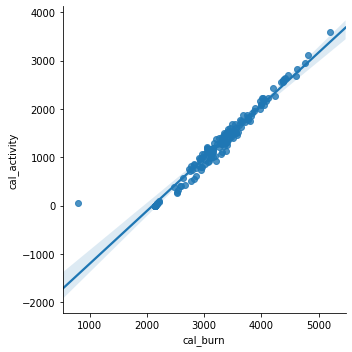

In [9]:
sns.lmplot(data=train,x="cal_burn",y="cal_activity")

### A. Impute `cal_activity` using BMR

Process:
1. Get median_bmr to get Armstrong's constant BMR.
2. Subset the week with missing values and zero in on the `cal_activity`.
3. If `cal_activity` = 0, impute calculated `cal_activity` using the formula. Otherwise, use the true `cal_activity` value.

In [10]:
median_bmr = (train.cal_burn - train.cal_activity).median()
print(f"Armstrong's Median BMR is: {median_bmr}")

Armstrong's Median BMR is: 1986.0


Add a column in train with a computed `cal_activity` based on formula.

In [11]:
train["calculated_cal_activity"] = train.cal_burn - median_bmr

Subset the days with missing values

In [12]:
missing_subset = train["2018-06-26":"2018-07-06"]

Use `np.where` to replace 0 with calculated cal_activity, and retain actual values if not 0.

In [13]:
missing_subset["cal_activity"] = np.where(missing_subset.cal_activity == 0, missing_subset.calculated_cal_activity, missing_subset.cal_activity)

Attach the subset back to train.

In [14]:
train.loc["2018-06-26":"2018-07-06","cal_activity"] = missing_subset.cal_activity

In [15]:
train["2018-06-26":"2018-07-06"] #Check if we have successfully imputed cal_activity

,index,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity,calculated_cal_activity
date,,,,,,,,,,,
2018-06-26,61,2144,0,0.00,0,1440,0,0,0,158.0,158.0
2018-06-27,62,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-06-28,63,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-06-29,64,2180,0,0.00,0,1437,3,0,0,39.0,194.0
2018-06-30,65,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-07-01,66,3090,4714,2.22,4,1005,232,0,0,1125.0,1104.0
2018-07-02,67,2204,172,0.08,0,1024,12,0,0,67.0,218.0
2018-07-03,68,2144,0,0.00,0,1440,0,0,0,158.0,158.0
2018-07-04,69,2183,0,0.00,0,1438,2,0,0,42.0,197.0


### B. Impute the Rest of the Missing Data

We still have other missing data from the following attributes:
- `steps`
- `distance`
- `floors`
- `min_active_light`
- `min_active_fairly`
- `min_active_very`

Unlike the `cal_activity` with heavy interdependence with known values in `cal_burn` (i.e., using BMR), the attributes above can be calculated using the mean of observations with similar daily profile to the ones missing.

The days with missing values is what we loosely described as "Lazy Days" where the `cal_burn` and `cal_activity` values are below the median. Specifically, the days with missing values have cal_burn of 2000-2500, when the median `cal_burn` is 3302.5 in train.

Armstrong was generally "lazy" on the days that we lost the data from!

With these in mind, we decide the imputation process to be as follows:
 1. Find similar-looking "Lazy Days" observations.
 2. Limit the observations with similar-looking "Lazy Days", that is, with `cal_burn` between 2000-2500.
 3. Get the mean values of attributes of "Lazy Days". These values are going to be the imputed constants for our missing values.
 5. Excluding values from July 1 and 2, 2018 which contain true values, impute the mean constants.

In [16]:
#Steps Mean Constant
mean_lds_steps = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].steps.mean()

#Distance Mean Constant
mean_lds_distance = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].distance.mean()

#Floors Mean Constant
mean_lds_floor = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].floors.mean()

#Lightly Active Minutes Mean Constant
mean_lds_light = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_light.mean()

#Fairly Active Minutes Mean Constant
mean_lds_fairly = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_fairly.mean()

#Very Active Minutes Mean Constant
mean_lds_very = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_very.mean()

In [17]:
missing_subset_21 = train["2018-06-26":"2018-06-30"]
missing_subset_22 = train["2018-07-03":"2018-07-06"]

In [18]:
missing_subset_21["steps"] = mean_lds_steps
missing_subset_21["distance"] = mean_lds_steps
missing_subset_21["floors"] = mean_lds_steps
missing_subset_21["min_active_light"] = mean_lds_light
missing_subset_21["min_active_fairly"] = mean_lds_fairly
missing_subset_21["min_active_very"] = mean_lds_very

missing_subset_22["steps"] = mean_lds_steps
missing_subset_22["distance"] = mean_lds_steps
missing_subset_22["floors"] = mean_lds_steps
missing_subset_22["min_active_light"] = mean_lds_light
missing_subset_22["min_active_fairly"] = mean_lds_fairly
missing_subset_22["min_active_very"] = mean_lds_very

Check what the two data frames contain.

In [22]:
print(missing_subset_21.index)
print(missing_subset_22.index)

DatetimeIndex(['2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29',
               '2018-06-30'],
              dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06'], dtype='datetime64[ns]', name='date', freq=None)


In [23]:
#attach the missing_subset_21 and 22 back to train
train.loc["2018-06-26":"2018-06-30"] = missing_subset_21
train.loc["2018-07-03":"2018-07-06"] = missing_subset_22

#drop extra columns
train.drop(columns=["calculated_cal_activity","index"],inplace=True)

## III. Explore

### A. Explore Monthly Patterns (if any) on Armstrong's Activity Level

In [ ]:
df = acquire.set_date_as_index(df)

In [39]:
df_month = df.resample("M").mean()

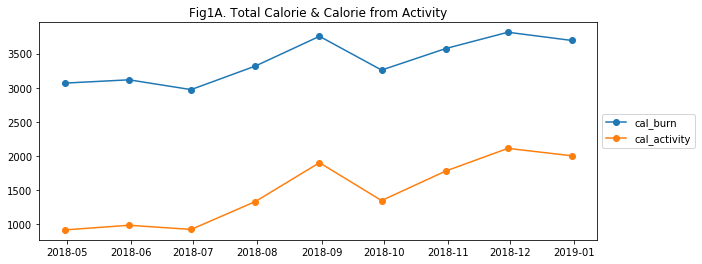

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['cal_burn','cal_activity']], marker='o')
plt.legend(['cal_burn', 'cal_activity'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig1A. Total Calorie & Calorie from Activity')
plt.show()

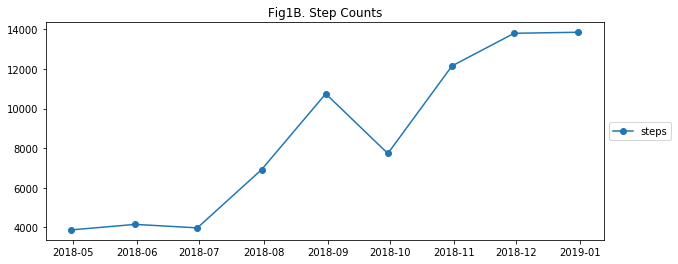

In [43]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['steps']], marker='o')
plt.legend(['steps'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig1B. Step Counts')
plt.show()

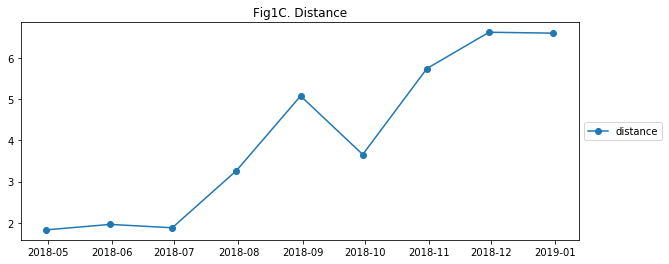

In [44]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['distance']], marker='o')
plt.legend(['distance'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig1C. Distance')
plt.show()

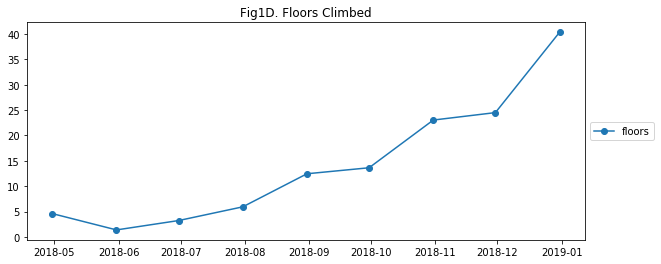

In [46]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['floors']], marker='o')
plt.legend(['floors'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig1D. Floors Climbed')
plt.show()

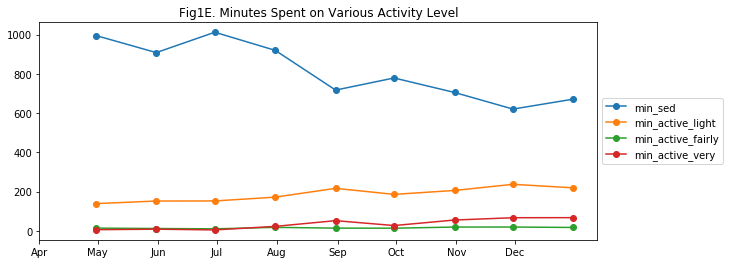

In [47]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['min_sed', 'min_active_light','min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_sed','min_active_light', 'min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-04","2018-05","2018-06","2018-07","2018-08","2018-09","2018-10","2018-11","2018-12"],["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title('Fig1E. Minutes Spent on Various Activity Level')
plt.show()

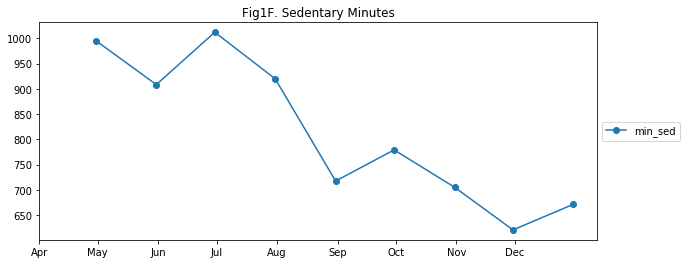

In [48]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['min_sed']], marker='o')
plt.legend(['min_sed'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-04","2018-05","2018-06","2018-07","2018-08","2018-09","2018-10","2018-11","2018-12"],["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title('Fig1F. Sedentary Minutes')
plt.show()

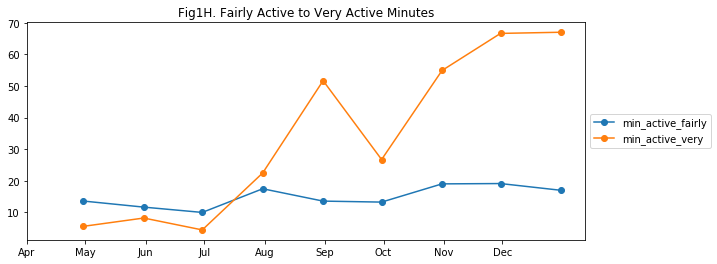

In [50]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-04","2018-05","2018-06","2018-07","2018-08","2018-09","2018-10","2018-11","2018-12"],["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title('Fig1H. Fairly Active to Very Active Minutes')

plt.show()

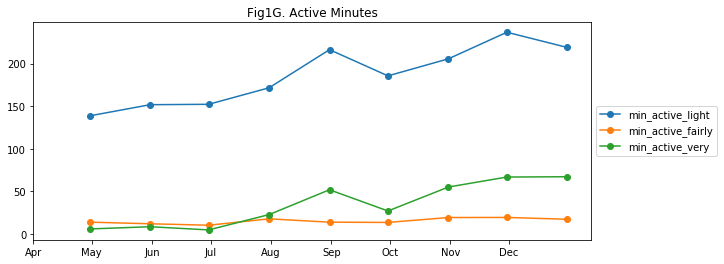

In [49]:
plt.figure(figsize=(10,4))
plt.plot(df_month.loc[:,['min_active_light','min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_active_light', 'min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-04","2018-05","2018-06","2018-07","2018-08","2018-09","2018-10","2018-11","2018-12"],["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title('Fig1G. Active Minutes')
plt.show()

In [51]:
# create date features and store into dataframe
df['months'] = df.index.strftime('%b')
train['weekday'] = train.index.strftime('%a')
train['weeks_of_yr'] = train.index.strftime('%U')
train['months'] = train.index.strftime('%b')

df.months.unique()

array(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype=object)

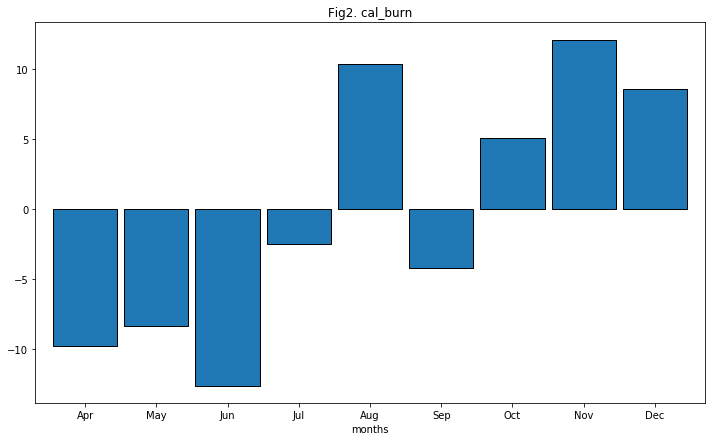

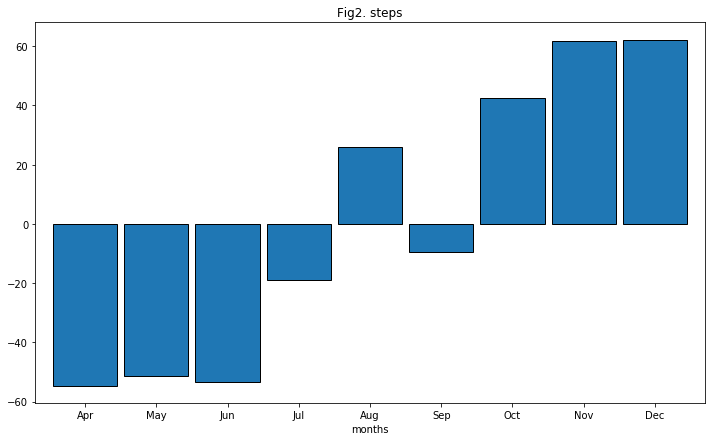

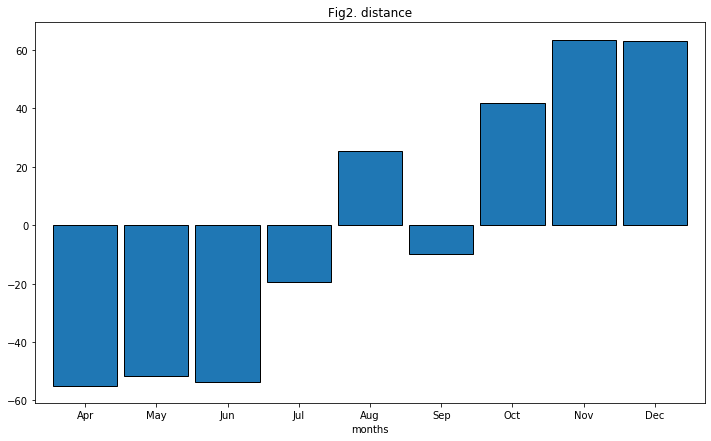

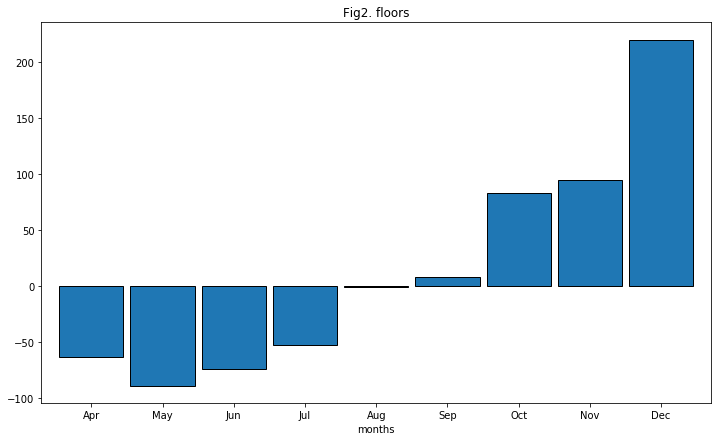

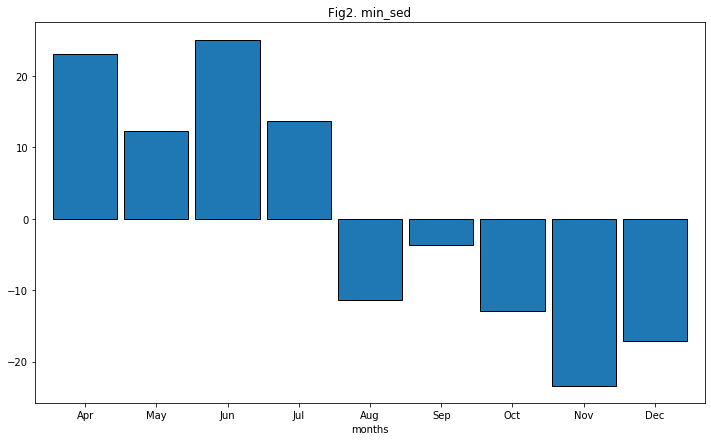

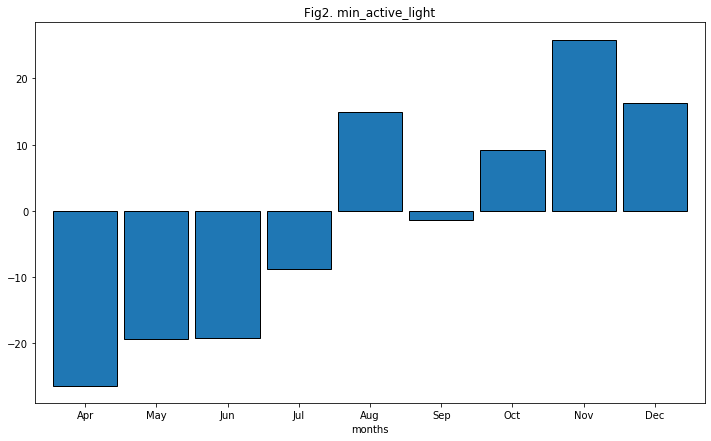

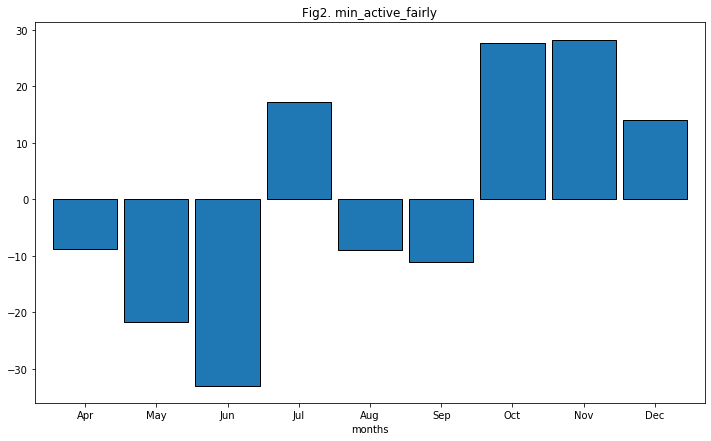

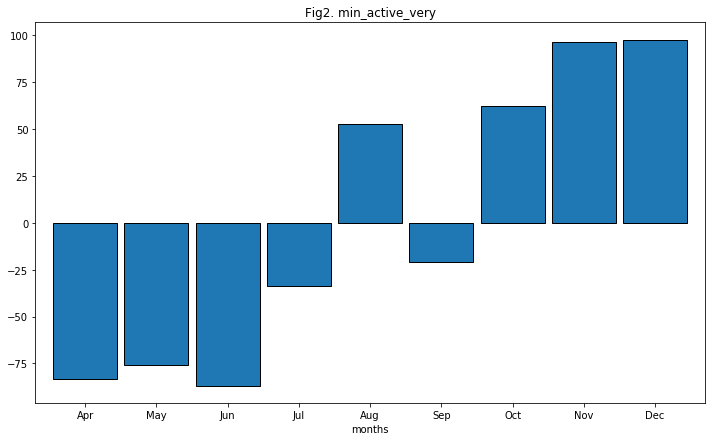

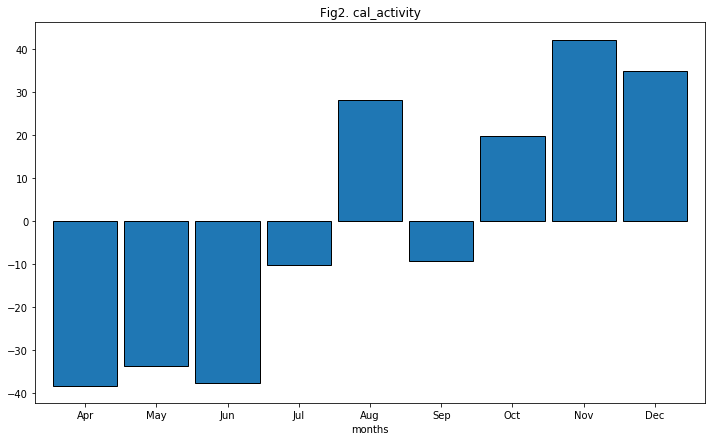

DataError: No numeric types to aggregate

In [52]:
for var in df.columns.to_list():
    order = df.months.unique()
    cal = pd.DataFrame()
    cal['ind'] = df.groupby('months')[var].mean().reindex(order)
    cal['avg'] = df[var].mean()
    cal['pct_error'] = ((cal['ind']-cal['avg']) / cal['avg'])*100
    cal['pct_error'].plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title('Fig2. '+var)
    plt.show()

<div class="alert alert-block alert-warning">
<b>Takeaway:</b>
Armstrong has a generally sedentary lifestyle with an activity level of "light". We see a heightened steps count in Oct-Dec (colder months). He was least active in July and September, which are summer months. So we don't think the seasons of the year affect his physical activity level.
</div>

### B. Explore Trend and Seasonality

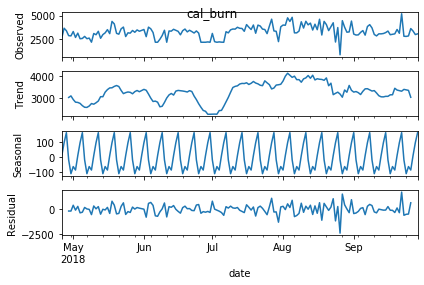

In [54]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("D").mean(), model='additive')
decomposition.plot().suptitle('cal_burn')
plt.show()

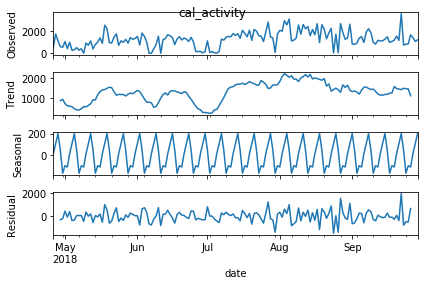

In [55]:
decomposition = sm.tsa.seasonal_decompose(train.cal_activity.resample("D").mean(), model='additive')
decomposition.plot().suptitle('cal_activity')
plt.show()

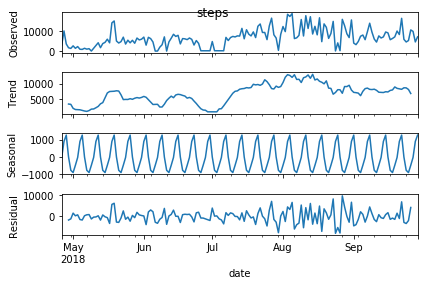

In [56]:
decomposition = sm.tsa.seasonal_decompose(train.steps.resample("D").mean(), model='additive')
decomposition.plot().suptitle('steps')
plt.show()

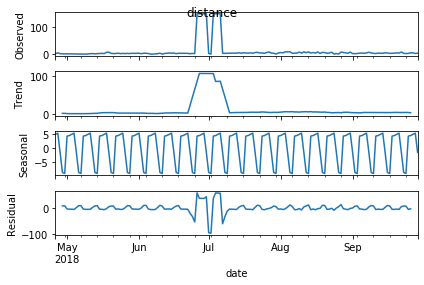

In [57]:
decomposition = sm.tsa.seasonal_decompose(train.distance.resample("D").mean(), model='additive')
decomposition.plot().suptitle('distance')
plt.show()

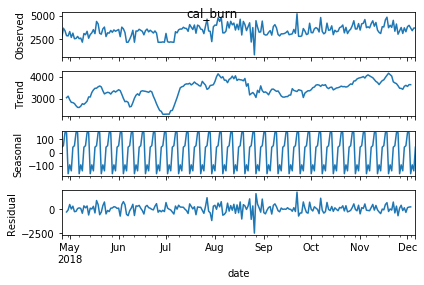

In [58]:
decomposition = sm.tsa.seasonal_decompose(df.cal_burn.resample("D").mean(), model='additive')
decomposition.plot().suptitle('cal_burn')
plt.show()

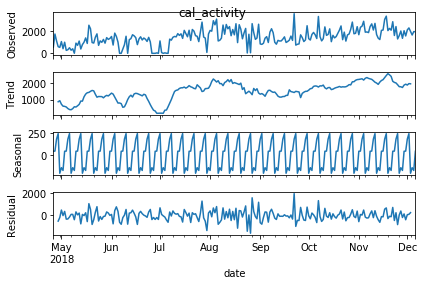

In [59]:
decomposition = sm.tsa.seasonal_decompose(df.cal_activity.resample("D").mean(), model='additive')
decomposition.plot().suptitle('cal_activity')
plt.show()

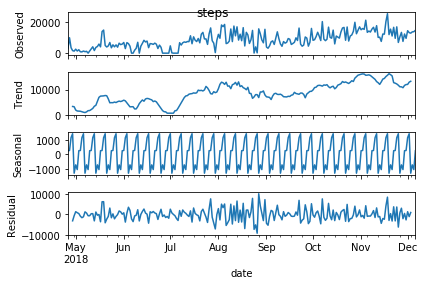

In [60]:
decomposition = sm.tsa.seasonal_decompose(df.steps.resample("D").mean(), model='additive')
decomposition.plot().suptitle('steps')
plt.show()

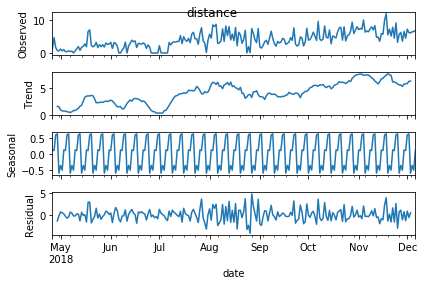

In [61]:
decomposition = sm.tsa.seasonal_decompose(df.distance.resample("D").mean(), model='additive')
decomposition.plot().suptitle('distance')
plt.show()

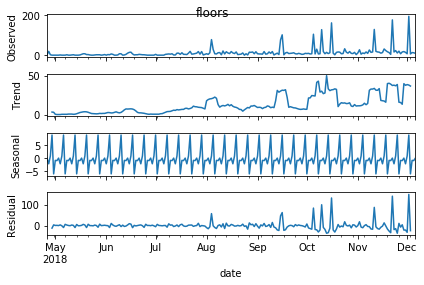

In [62]:
decomposition = sm.tsa.seasonal_decompose(df.floors.resample("D").mean(), model='additive')
decomposition.plot().suptitle('floors')
plt.show()

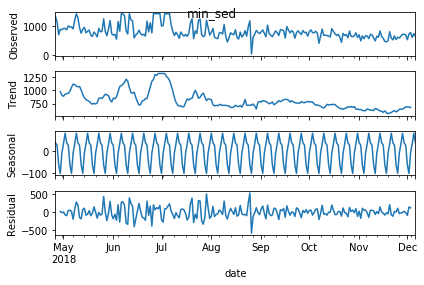

In [63]:
decomposition = sm.tsa.seasonal_decompose(df.min_sed.resample("D").mean(), model='additive')
decomposition.plot().suptitle('min_sed')
plt.show()

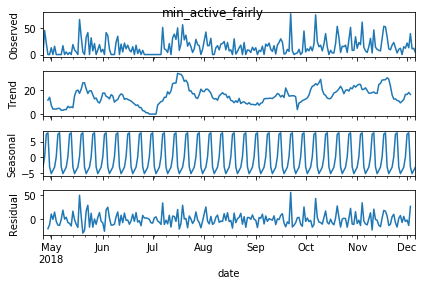

In [64]:
decomposition = sm.tsa.seasonal_decompose(df.min_active_fairly.resample("D").mean(), model='additive')
decomposition.plot().suptitle('min_active_fairly')
plt.show()

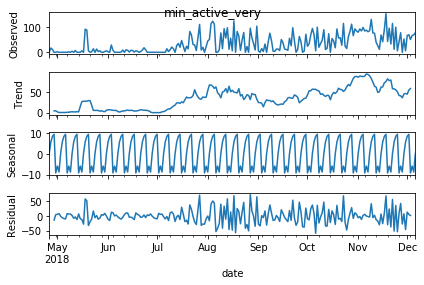

In [65]:
decomposition = sm.tsa.seasonal_decompose(df.min_active_very.resample("D").mean(), model='additive')
decomposition.plot().suptitle('min_active_very')
plt.show()

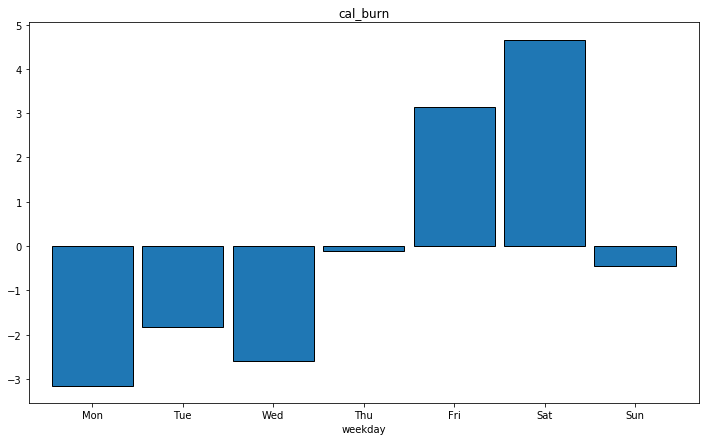

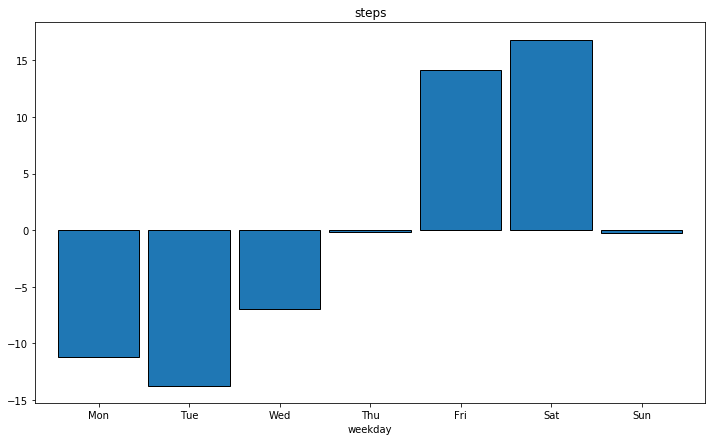

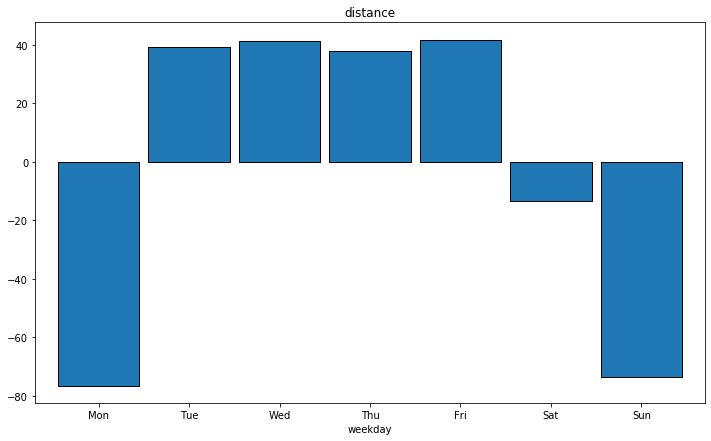

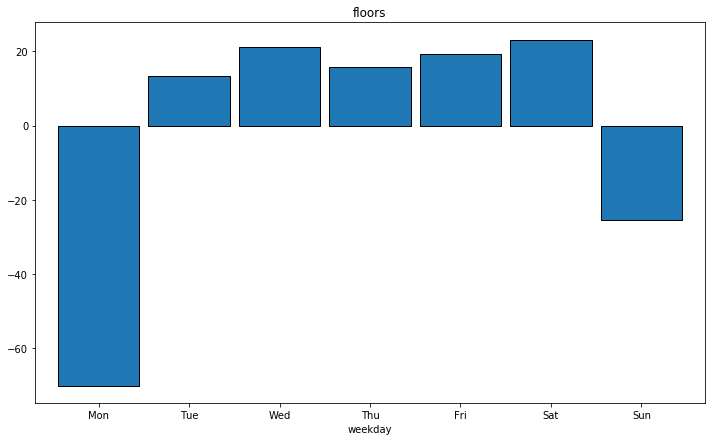

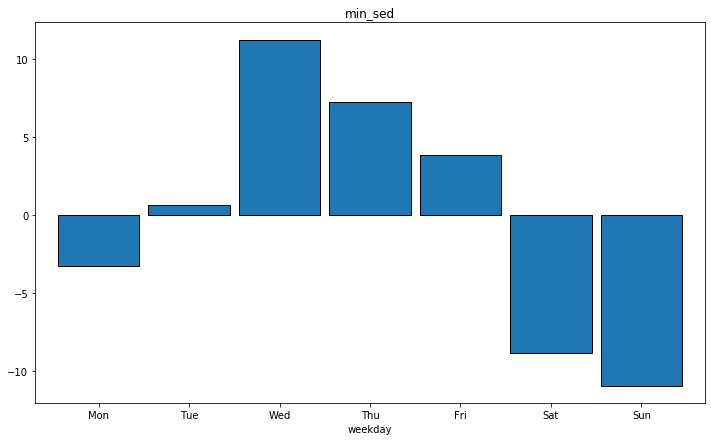

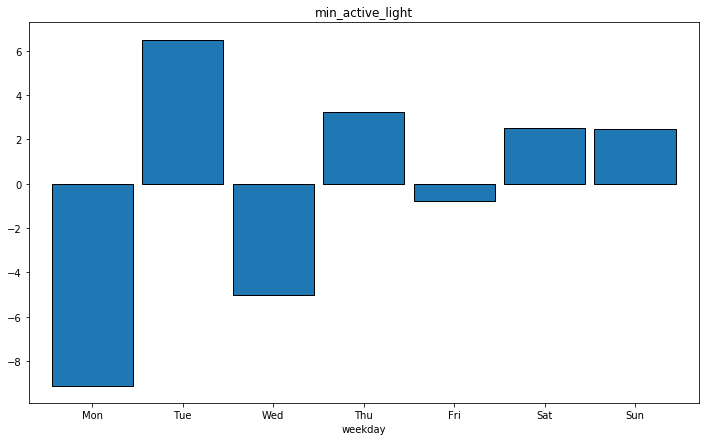

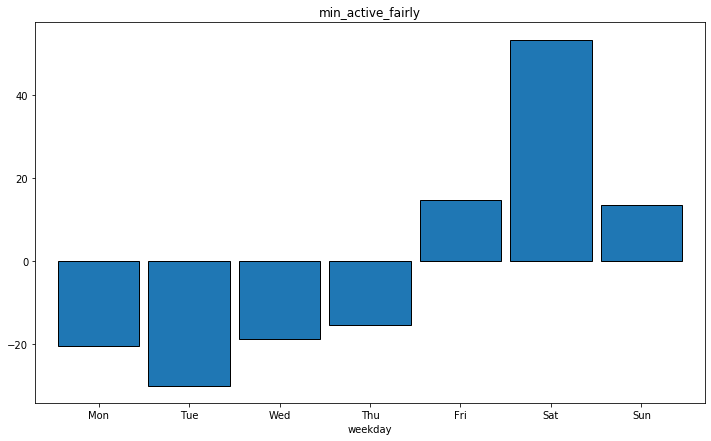

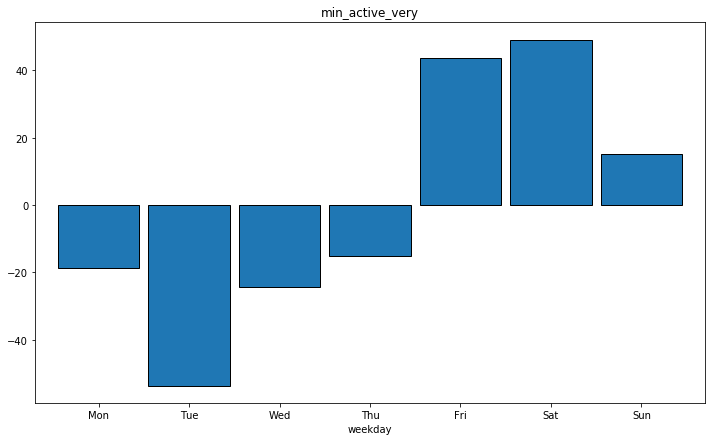

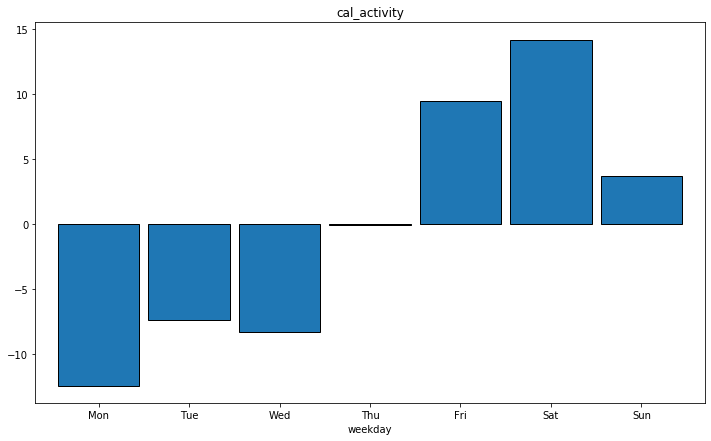

DataError: No numeric types to aggregate

In [66]:
for var in train.columns.to_list():
    order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    #train.groupby('weekday')[var].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    cal = pd.DataFrame()
    cal['ind'] = train.groupby('weekday')[var].mean().reindex(order) 
    cal['avg'] = train[var].mean()
    cal['pct_error'] = ((cal['ind']-cal['avg']) / cal['avg'])*100
    cal['pct_error'].plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    
    #train_weekday = train.groupby('weekday')[var].mean().reindex(order) 
    #train_weekday.plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title(var)
    plt.show()

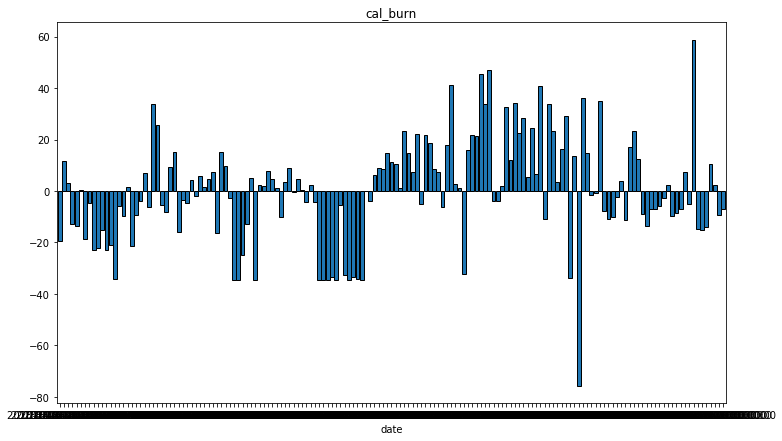

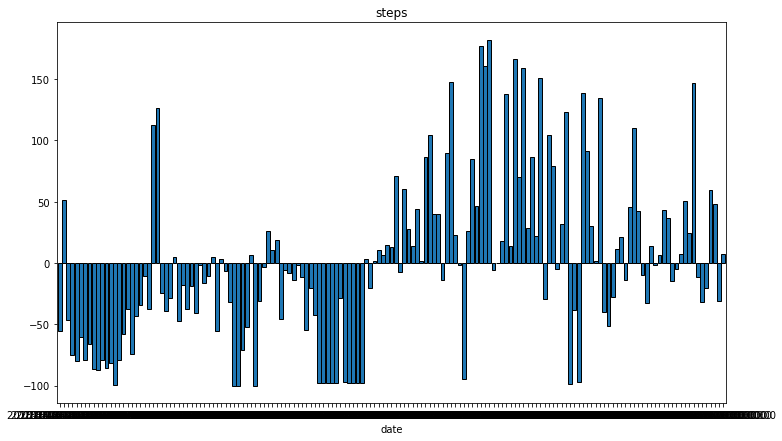

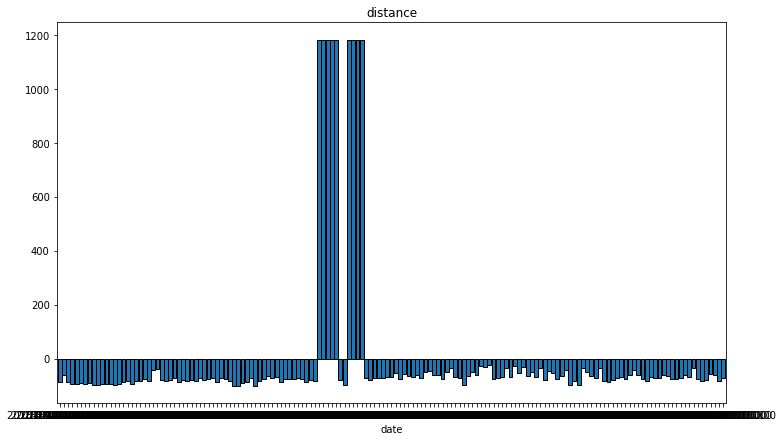

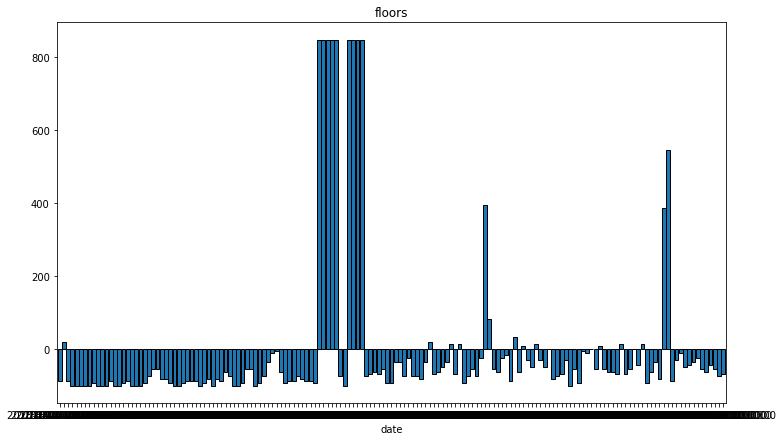

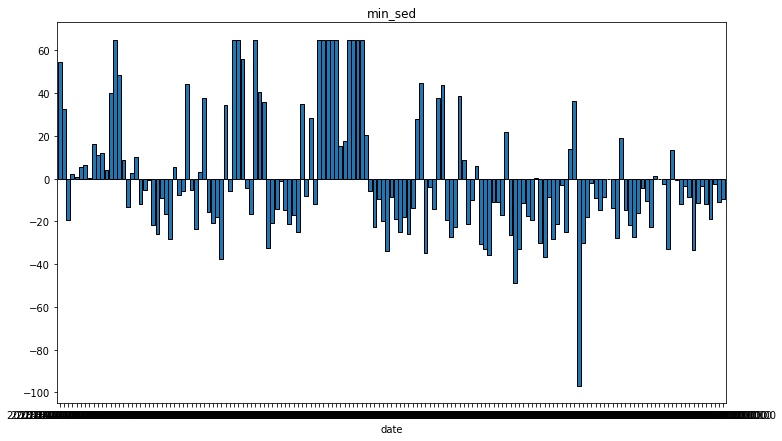

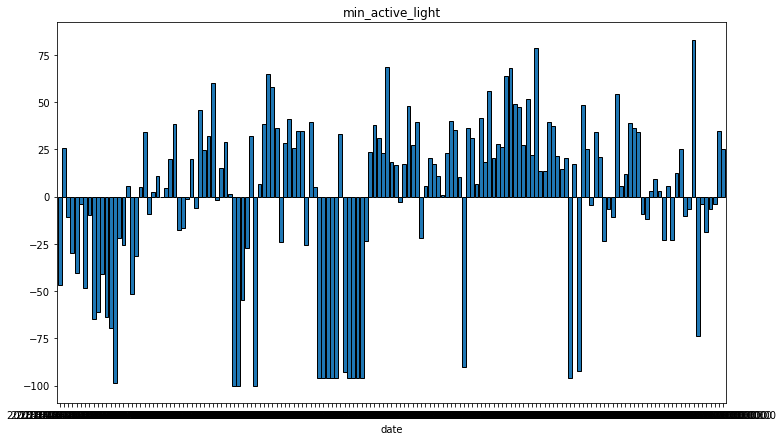

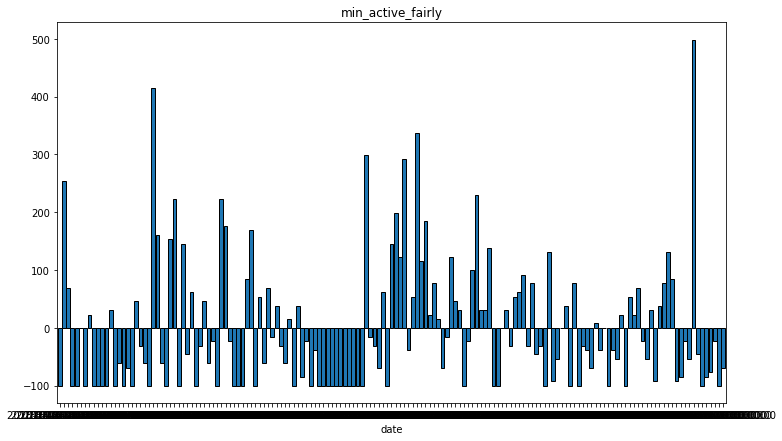

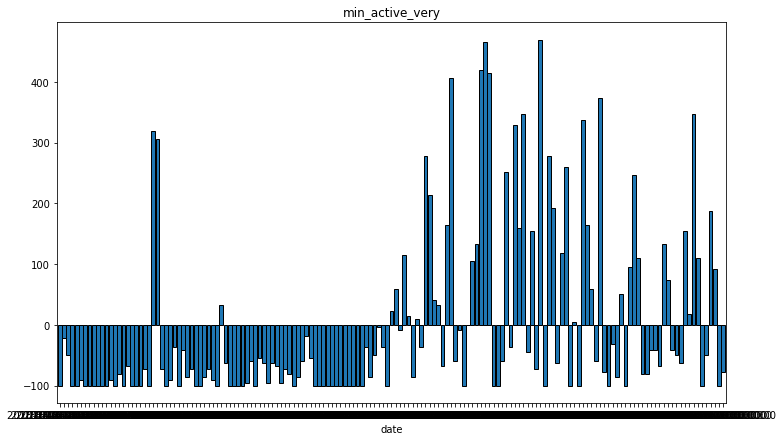

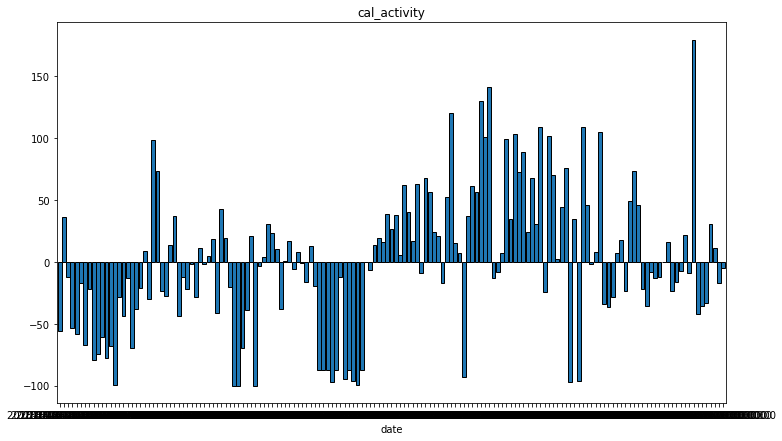

TypeError: Could not convert ThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSatSunMonTueWedThuFriSat to numeric

In [67]:
for var in train.columns.to_list():
    #order = train.weeks_of_yr'.unique()
    cal = pd.DataFrame()
    cal['ind'] = train[var]
    cal['avg'] = train[var].mean()
    cal['pct_error'] = ((cal['ind']-cal['avg']) / cal['avg'])*100
    cal['pct_error'].plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    #train_weekday = train.groupby('weekday')[var].mean().reindex(order) 
    #train_weekday.plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title(var)
    plt.show()

<div class="alert alert-block alert-warning">
<b>Takeaways:</b>

1. When observing Armstrong's Fitbit data on a daily basis, it is clear that he was trending toward a more active person toward later part of year 2018.  His activity log also show weekly seasonality.  
    
2. When observing weekly pattern with percent diviation from average, Armstrong demonstrated much lower activity level or lower calorie burned.

3. Monday is the lowest when compared with other days of the week.
</div>

## IV. Model

### A. Model Based on Original Train Data and Forecast Test Data

Run each attribute in each four models (simple average, moving average, holt linear, holt exponential smoothing) and create data frames for all predicted values.

There are four functions from the model.py module that are being run under the hood to perform these modeling, namely:
- `forecast_simple`
- `forecast_moving`
- `forecast_holt_linear`
- `forecast_holt_es`

Also in the model.py module, `tabulate_forecasts` is a function created to tabulate the predicted values (test) for each model.

In [70]:
tab_ca = model.tabulate_forecasts("cal_activity",test,train)
tab_steps = model.tabulate_forecasts("steps",test,train)
tab_floors = model.tabulate_forecasts("floors",test,train)
tab_distance = model.tabulate_forecasts("distance",test,train)
tab_light = model.tabulate_forecasts("min_active_light",test,train)
tab_fairly = model.tabulate_forecasts("min_active_fairly",test,train)
tab_very = model.tabulate_forecasts("min_active_very",test,train)

Let's have a look at one of them:

In [79]:
tab_very.head()

,min_active_very,simple,moving,holt_yhat,holtes_yhat
date,,,,,
2018-09-30,72,21.949045,23.857143,-1.016608,-3.682426
2018-10-01,24,21.949045,23.857143,-10.764557,-17.303571
2018-10-02,34,21.949045,23.857143,-20.512507,-30.924716
2018-10-03,69,21.949045,23.857143,-30.260456,-44.545861
2018-10-04,95,21.949045,23.857143,-40.008405,-58.167006


### B. Evaluate by Comparing the Root Mean Squared Error (RMSE)

`get_all_rmse` is a connector function that gives a list of the models' RMSEs for each attribute from the tabulated results above.

In [87]:
rmsey, rmse_steps, rmse_distance, rmse_floors, rmse_light, rmse_fairly, rmse_very = model.get_all_rmse(test,train)

`generate_rmse_table` gives us the RMSE of each model on each attribute in a pretty tabular format.

In [88]:
rmse_table = model.generate_rmse_table(rmsey, rmse_steps, rmse_distance, rmse_floors, rmse_light, rmse_fairly, rmse_very)

In [89]:
rmse_table

,simple,moving,holt_linear,holt_expo
cal_act,854.642206,993.755555,1520.838152,680.954286
steps,7547.199919,7389.596143,5427.324311,5124.114636
distance,5.762426,3.557947,4.582711,4.572269
floors,41.326009,44.070077,70.599350,40.405065
light,71.007956,79.252382,66.192526,54.430802
fairly,17.492802,22.566329,16.669057,17.881464
very,52.365541,50.943590,39.889390,35.453073


> **Note:** Parameters for Holt's Linear and Holt's Exponential Smoothing that give the lowest RMSE were derived from trial and error.  
> **Takeaway:** Seasonal Smoothing does not make a difference when used in our data for Exponential Smoothing.

### C. Forecast based on New Train and Test

Forecast each attribute based on the respective models that gave the least RMSE.

We will use a New Train and Test for this forecasting.

`new_train` contains the data from the beginning of the original data set until the day before our 2-weeks of missing data, i.e., July 25, 2018.

`new_test` is the 2-week of missing data that we want to predict, that is, from June 26 to July 6, 2018.

In [94]:
new_train = train[:"2018-06-25"]
new_test = df.copy().loc["2018-06-26":"2018-07-06"]

Let's recall what our original data frame looks like with the 2 weeks of missing data.

In [95]:
df["2018-06-26":"2018-07-06"]

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity,months
date,,,,,,,,,,
2018-06-26,2144,0,0.00,0,1440,0,0,0,0,Jun
2018-06-27,2145,0,0.00,0,1440,0,0,0,0,Jun
2018-06-28,2145,0,0.00,0,1440,0,0,0,0,Jun
2018-06-29,2180,0,0.00,0,1437,3,0,0,39,Jun
2018-06-30,2145,0,0.00,0,1440,0,0,0,0,Jun
2018-07-01,3090,4714,2.22,4,1005,232,0,0,1125,Jul
2018-07-02,2204,172,0.08,0,1024,12,0,0,67,Jul
2018-07-03,2144,0,0.00,0,1440,0,0,0,0,Jul
2018-07-04,2183,0,0.00,0,1438,2,0,0,42,Jul


From the `rmse_table` above we will use the following models to forecast the missing data on the attributes on `new_test`.

- Steps - Holt's Exponential Smoothing  
- Distance - Moving Average
- Floors - Holt's Exponential Smoothing
- Minutes of being Lightly Active - Holt's Exponential Smoothing
- Minutes of being Fairly Active - Holt's Linear
- Minutes of being Very Active - Holt's Exponential Smoothing
- Calorie from Activity - Holt's Exponential Smoothing

Forecast `steps` using Holt's Exponential Smoothing. Create `predictions` data frame from therein.

In [98]:
predictions = model.forecast_holt_es("steps",new_train,new_test,.1,.13)
predictions[0] = predictions[0].astype("int")
predictions = predictions.rename(columns={0:"steps_pd"})

Forecast `distance` using Moving Average.

In [103]:
distance_ma = model.forecast_moving("distance",new_train)
predictions["distance_pd"] = distance_ma

Forecast `floors` using Holt's Exponential Smoothing.

In [104]:
floors_holtes = model.forecast_holt_es("floors",new_train,new_test,.01,.01)
predictions["floors_pd"] = floors_holtes

#transform negative values to 0 because floors as an attribute has an absolute 0.
predictions["floors_pd"] = np.where(predictions.floors_pd < 0, 0, predictions.floors_pd)

Forecast `min_active_light` using Holt's Exponential Smoothing.

In [105]:
light_holtes = model.forecast_holt_es("min_active_light",new_train,new_test,.05,.01)
predictions["min_active_light_pd"] = light_holtes

Forecast `min_active_fairly` using Holt's Exponential Smoothing. The model will return negative values, which we will convert to 0.

In [106]:
fairly_holt = model.forecast_holt_linear("min_active_fairly",new_train,new_test,.08,.12)
predictions["min_active_fairly_pd"] = fairly_holt


#transform negative values to 0 because minutes of activity as an attribute has an absolute 0.
predictions["min_active_fairly_pd"] = np.where(predictions.min_active_fairly_pd < 0, 0, predictions.min_active_fairly_pd)

Forecast `min_active_very` using Holt's Exponential Smoothing.

In [107]:
very_holtes = model.forecast_holt_es("min_active_very",new_train,new_test,.01,.01)
predictions["min_active_very_pd"] = very_holtes

Forecast `cal_activity` using Holt's Exponential Smoothing.

In [115]:
cal_active = model.forecast_holt_es("cal_activity",new_train,new_test,.1,.13)
predictions["cal_activity_pd"] = cal_active

See what our final predictions data frame looks like.

In [116]:
predictions

,steps_pd,distance_pd,floors_pd,min_active_light_pd,min_active_fairly_pd,min_active_very_pd,cal_activity_pd
date,,,,,,,
2018-06-26,5534,2.428571,4.101331,213.765830,0.0,6.862263,1272.677400
2018-06-27,5826,2.428571,4.147669,215.408941,0.0,6.862011,1329.839167
2018-06-28,6118,2.428571,4.194008,217.052052,0.0,6.861758,1387.000935
2018-06-29,6410,2.428571,4.240346,218.695162,0.0,6.861505,1444.162703
2018-06-30,6701,2.428571,4.286684,220.338273,0.0,6.861252,1501.324470
2018-07-01,6993,2.428571,4.333022,221.981384,0.0,6.861000,1558.486238
2018-07-02,7285,2.428571,4.379360,223.624494,0.0,6.860747,1615.648005
2018-07-03,7577,2.428571,4.425698,225.267605,0.0,6.860494,1672.809773
2018-07-04,7868,2.428571,4.472036,226.910716,0.0,6.860241,1729.971541


<div class="alert alert-block alert-warning">
<b>Final Remarks:</b>

It seems like our predicted values make sense for "Lazy Days" as described above and differ minimally from the imputed values prior to the modeling phase.

The data gives us confidence that we undertook a solid process and that the models we chose for each attribute are appropriate.
</div>

### C. Save a CSV file of the Predicted Values

In [110]:
predictions.to_csv('predictions_for_missing_weeeks.csv')